# using Plots, DelimitedFiles, LinearAlgebra, Statistics, Revise
pwd()
cd("..")
pwd()

In [2]:
includet("src/BasisFunctions.jl")
includet("src/BifurcationGenerator.jl")
includet("src/Hookstep.jl")
includet("src/tw_newton.jl")
includet("src/VelocityGraphs.jl")

using .BasisFunctions
using .BifurcationGenerator
using .Hookstep
using .TW_Newton

myreaddlm(filename) = readdlm(filename, comments=true, comment_char='%')

Velocity field visualization functions loaded!

Available functions:
  - velocity_fields(Ψ, solution; save_path=...)
  - velocity_fields_dns(root; save_path=...)
  - velocity_fields_comparison(Ψ, solution, root; save_dir=...)


myreaddlm (generic function with 1 method)

In [3]:
@kwdef struct TWConfig
    name::Symbol
    Re_values::Vector{Int}
    cx0::Float64
    cz0::Float64
    symmetry_group::SymmetryGroup
end
const TW_CONFIGS = Dict(
    :TW1 => TWConfig(
        name = :TW1,
        Re_values = [200, 300],
        cx0 = 0.0,
        cz0 = 0.009,
        symmetry_group = SymmetryGroup(:TW1)
    ),
    :TW2 => TWConfig(
        name = :TW2,
        Re_values = [250, 300],
        cx0 = 0.3959,
        cz0 = 0.0,
        symmetry_group = SymmetryGroup(:TW2)
    ),
    :TW3 => TWConfig(
        name = :TW3,
        Re_values = [250, 300],
        cx0 = 0.4646,
        cz0 = 0.0,
        symmetry_group = SymmetryGroup(:TW2)
    )
)

Dict{Symbol, TWConfig} with 3 entries:
  :TW2 => TWConfig(:TW2, [250, 300], 0.3959, 0.0, SymmetryGroup(:TW2))
  :TW1 => TWConfig(:TW1, [200, 300], 0.0, 0.009, SymmetryGroup(:TW1))
  :TW3 => TWConfig(:TW3, [250, 300], 0.4646, 0.0, SymmetryGroup(:TW2))

In [4]:
# discretizations = ((1, 1, 2), (1, 2, 2), (2, 2, 4), (3, 3, 6), (4, 4, 8), (5, 5, 10), (6, 6, 12))
discretizations = ((1, 1, 2), (1, 2, 2), (2, 2, 2), (2, 2, 4), (2, 3, 4), (3, 3, 4), (3, 3, 6))
for jkl in discretizations
    println("generating $jkl")
    _, ijkl, _, _, _ = generate_psi_ijkl_a_b_n(jkl::Tuple{Int64, Int64, Int64}; α = 1, γ = 2, chebyshev=true, symmetry=SymmetryGroup(:TW1))
    J, K, L = jkl
    ijkl2file(ijkl, "ijkls/ijkl-sxytxz-$J-$K-$L")
end


generating (1, 1, 2)
generating (1, 2, 2)
generating (2, 2, 2)
generating (2, 2, 4)
generating (2, 3, 4)
generating (3, 3, 4)
generating (3, 3, 6)


In [5]:
cd("data/tw1")
for jkl in discretizations
    # e.g. projectfield ijkl-sztx-1-2-2.asc uTW1-2pi1piRe200.nc TW1-2pi1piRe200-1-2-2
    J, K, L = jkl
    cmd = ` projectfield ../../ijkls/ijkl-sxytxz-$J-$K-$L.asc uTW1-2pi1piRe200.nc TW1-2pi1piRe200-$J-$K-$L`
    run(cmd)
end
cd("../..")

alpha, gamma == 1, 2.00000000000006
Nx, Ny, Nz == 40, 49, 40
Reading ijkl indices of basis set from file
reading N == 24 ijkl indices
ijkl[0] == 1 0 0 1
L == max l == 2
Constructing Legendre polynomials
resized, trying to make first polynomial
0 0 0 
Assigning Polynomial, size = 1 
made first polynomial
Assigning Polynomial, size = 0 1 
Assigning Polynomial, size = -0.5 0 1.5 
Print Legendre polynomials ...
P[0] == 1
P[1] == 0 +  y
P[2] == -0.5 + 1.5 y^2
Constructing S, and Sprime polynomials
Assigning Polynomial, size = 0 1 0 -0.33333333333333331 
2S[0] == 0 + 2 y - 0.66666666666666663 y^3
Assigning Polynomial, size = 1 0 -2 0 1 
Assigning Polynomial, size = 0 1 0 -2 0 1 
Assigning Polynomial, size = 1 0 -1 
Assigning Polynomial, size = 0 -4 0 4 
Assigning Polynomial, size = 1 0 -6 0 5 
Generating psi[1] == psi(1, 0, 0, 1)
Generating psi[2] == psi(3, 0, 0, 0)
Generating psi[3] == psi(3, 0, 0, 2)
Generating psi[4] == psi(1, 0, -1, 0)
Generating psi[5] == psi(1, 0, -1, 2)
Generating psi

In [26]:
chflow_norm = 0.275751
# Global Parameters
α, γ = 1, 2
ftol = 1e-8
data = []

function percent_error(actual, guess)
    return abs(guess - actual) / actual * 100
end

function run_parameter_search(mode::Symbol, JKL::NTuple{3, Int})
    Re = 200
    config = TW_CONFIGS[mode]

    output = []

    println("Running $(config.name) at Re=$Re, JKL=$JKL")
    println("cx0=$(config.cx0), cz0=$(config.cz0), symmetry=$(config.symmetry_group)")
    Ψ, ijkl = generate_psi_ijkl(JKL; α=α, γ=γ, symmetry=config.symmetry_group)
    A_of_Re, Cx, Cz, N = tw_matrices(Ψ)
    A = A_of_Re(Re)
    Nmodes = length(Ψ)

    # Load initial guess
    x0 = myreaddlm("./data/tw1/x$(config.name)-2pi1piRe$(Re)-$(JKL[1])-$(JKL[2])-$(JKL[3]).asc")
    cx0 = config.cx0
    cz0 = config.cz0
    z0 = [x0; cx0; cz0]

    println("Starting Residual: ", norm(residual(x0, cx0, cz0, A, Cx, Cz, N)))

    println("Solving with hookstep...")
    hookstep_sol, hookstep_cx, hookstep_cz, hookstep_iterates = newton_hookstep_bordered!(x0, cx0, cz0; A=A, Cx=Cx, Cz=Cz, N=N, verbose=false)
    println("Search complete.")

    println("Norm of solution: ", norm(hookstep_sol))
    println("Wave speed in x: ", hookstep_cx)
    println("Wave speed in z: ", hookstep_cz)

    push!(output, (hookstep_sol, hookstep_cx, hookstep_cz, hookstep_iterates))
    println("\nRun complete.\n\n")
    return output
end

run_parameter_search (generic function with 1 method)

In [ ]:
for jkl in discretizations
    x = run_parameter_search(:TW1, jkl)[1][1]
    println(size(x))
    println(norm(x))
    println(x)
    push!(data, percent_error(chflow_norm, norm(x)))
end

In [28]:
# for jkl in discretizations
#     x = myreaddlm("data/tw1/xTW1-2pi1piRe200-$(jkl[1])-$(jkl[2])-$(jkl[3]).asc")
#     println(size(x))
#     println(norm(x))
#     println(x)
#     push!(data, percent_error(chflow_norm, norm(x)))
# end

Running TW1 at Re=200, JKL=(1, 1, 2)
cx0=0.0, cz0=0.009, symmetry=SymmetryGroup(:TW1)
Starting Residual: 0.014496906417755005
Solving with hookstep...
Search complete.
Norm of solution: 2.672795055366894e-9
Wave speed in x: 0.0
Wave speed in z: 0.00011604478950972912


Now verifying solution by a timestepped approximation:
Starting time evolution...
Evolution finished at T = 5.0
Calculating analytically shifted state...

--- Verification Results ---
L2 Error between simulated and analytically shifted wave: 5.900105378778903e-12
Result: The solution behaves like a true traveling wave.

Run complete.


(24,)
2.672795055366894e-9
[-2.0229068156221275e-12, -6.920894319185449e-14, -6.420310503558864e-15, -2.5286284214377054e-9, -2.1226315327162094e-10, -4.7156873737716085e-11, 8.301724481736855e-10, 7.058765924262452e-11, -1.5867751146275433e-11, 4.3999508245225606e-14, 1.6668525092353113e-12, -1.392159661114441e-11, -1.8525805528060692e-11, -4.1785884230682624e-13, 5.1393382185475623e-11, 

In [29]:
data



7-element Vector{Any}:
 99.99999903072154
 40.23236121173206
 55.207188458451164
 59.36018857720392
 64.55481653774483
 60.212132498947526
 46.29280419009483

In [32]:
dimension_vector = []
for jkl in discretizations
    x = myreaddlm("data/tw1/xTW1-2pi1piRe200-$(jkl[1])-$(jkl[2])-$(jkl[3]).asc")
    push!(dimension_vector, size(x)[1])
end

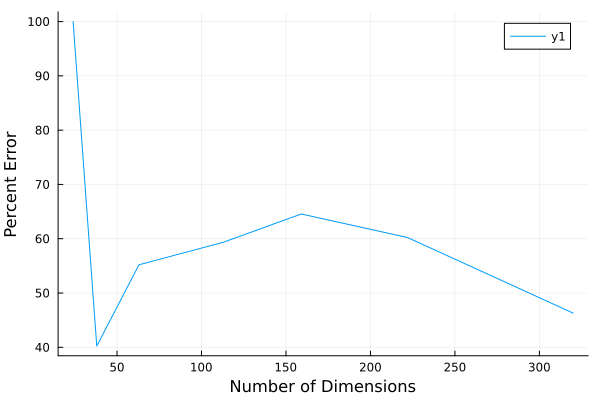

In [35]:
Plots.plot(dimension_vector, data, ylabel="Percent Error", xlabel = "Number of Dimensions")